<a href="https://colab.research.google.com/github/felipemaiapolo/prompteval/blob/main/notebooks/PromptEval_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/felipemaiapolo/prompteval.git
!pip install -U sentence-transformers

Cloning into 'prompteval'...
remote: Enumerating objects: 231, done.
remote: Counting objects: 100% (231/231), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 231 (delta 101), reused 180 (delta 72), pack-reused 0
Receiving objects: 100% (231/231), 23.68 MiB | 5.65 MiB/s, done.
Resolving deltas: 100% (101/101), done.
Updating files: 100% (154/154), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 1.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidi

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from prompteval.prompteval.methods import StratSample, ExtendedRaschModel

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In this tutorial, we use data from MMLU, but you can play with thw BBH and LMentry as well. Loading correctness data:

In [4]:
with open("prompteval/data/Ys.pickle", 'rb') as handle:
  Ys = pickle.load(handle)

benchmark = 'MMLU'
task = 'high_school_biology'

For each one of the 15 LLMs, we have a "correctness" array (rows give different formats while coolumns give different examples). Let's check the distribution of scores within each model:

[]

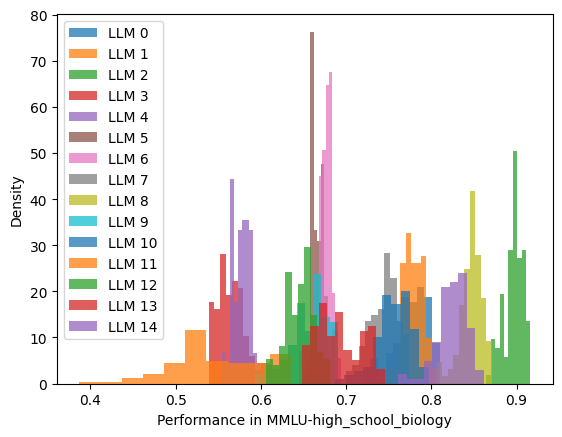

In [5]:
for i,Y in enumerate(Ys[benchmark][task]):
  plt.hist(Y.mean(1), alpha=.75, density=True, label=f"LLM {i}")
plt.xlabel(f"Performance in {benchmark}-{task}")
plt.ylabel("Density")
plt.legend()
plt.plot()

Let us predict the performance distribution for on of the LLMs. We will fix our budget to $B=1000$ (roughly $3.2\%$ of total) and we will not use any covariates at this stage. Sampling entries:

In [6]:
llm = 11
Y = Ys[benchmark][task][llm]
Y.shape

(100, 310)

In [7]:
budget = 1000
seen_examples = StratSample(np.zeros(Y.shape).astype(bool), budget, random_seed=0)
seen_examples

array([[False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

`seen_examples` gives us the entries in which we observe `Y`'s. Let us create `Y_seen`:

In [8]:
Y_seen = Y.copy()
Y_seen[~seen_examples] = -99 #just a placeholder for non-observed
Y_seen

array([[-99, -99, -99, ..., -99, -99,   0],
       [-99, -99, -99, ..., -99, -99, -99],
       [-99, -99, -99, ..., -99, -99, -99],
       ...,
       [-99, -99, -99, ..., -99,   1, -99],
       [-99, -99, -99, ..., -99, -99, -99],
       [-99, -99, -99, ..., -99, -99, -99]], dtype=int8)

Fitting model and obtain predicted distribution (and compare to simple baseline):

In [9]:
extended_rasch = ExtendedRaschModel()
extended_rasch.fit(seen_examples, Y_seen)

In [10]:
S = Y.mean(1)
S_hat = extended_rasch.get_Y_hat().mean(1)
S_hat_baseline = [Y_seen[i,s].mean() for i,s in enumerate(seen_examples)]

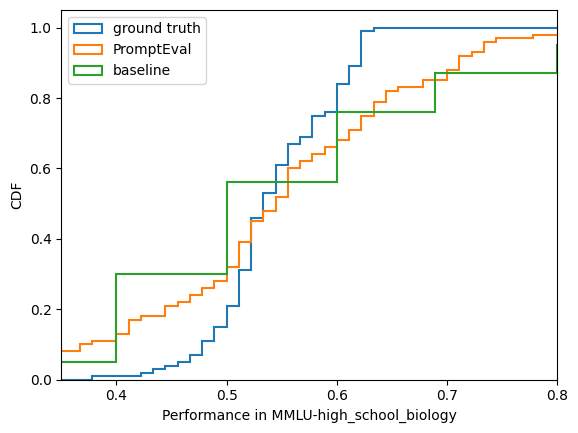

In [11]:
bins = np.linspace(0, 1.1, 100)
plt.hist(S, density=True, cumulative=True, bins=bins, histtype='step', linewidth=1.5, label='ground truth')
plt.hist(S_hat, density=True, cumulative=True, bins=bins, histtype='step', linewidth=1.5, label='PromptEval')
plt.hist(S_hat_baseline, density=True, cumulative=True, bins=bins, histtype='step', linewidth=1.5, label='baseline')
plt.xlim(0.35,.8)
plt.legend(fontsize=10)
plt.xlabel(f"Performance in {benchmark}-{task}")
plt.ylabel("CDF")
plt.show()

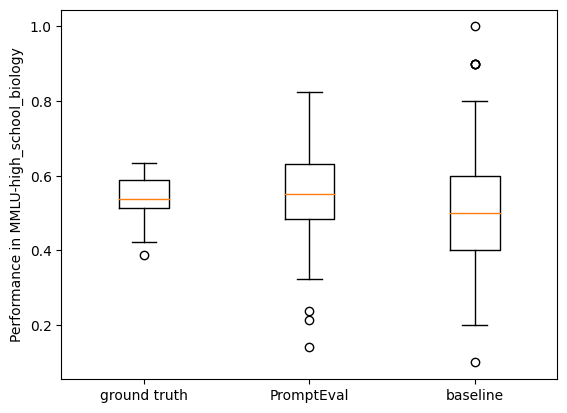

In [12]:
data = [S, S_hat, S_hat_baseline]
labels = ['ground truth', 'PromptEval', 'baseline']
plt.boxplot(data, labels=labels)
plt.xlim(0.5, 3.5)
plt.ylabel(f"Performance in {benchmark}-{task}")
plt.show()

We can see that PromptEval does better than the baseline and have accurate estimates for central quantiles (median).

Now, we improve the results by including some covariates for prompt templates.

In [13]:
templates = pd.read_csv(f'prompteval/data/templates/{benchmark}/{task}.csv')
templates = list(templates.iloc[:,1])
templates[:5]

['The\n following\n are\n multiple\n choice\n questions\n (WITH\n answers)\n about\n {topic}/\n {question}/\n Answers:\n {choices}/\n Answer:',
 'The\n following\n are\n multiple\n choice\n questions\n (With\n answers)\n about\n {topic}|\n {question}|\n Answers:\n {choices}|\n Answer:',
 "The\n following\n are\n multiple\n choice\n questions\n (with\n answers)\n about\n {topic}'\n {question}'\n Answers:\n {choices}'\n Answer:",
 'The\nfollowing\nare\nmultiple\nchoice\nquestions\n(WITH\nanswers)\nabout\n{topic}"\n{question}"\nAnswers:\n{choices}"\nAnswer:',
 'The\nfollowing\nare\nmultiple\nchoice\nquestions\n(WITH\nanswers)\nabout\n{topic}<sep>\n{question}<sep>\nAnswers:\n{choices}<sep>\nAnswer:']

In [14]:
pca_dim = 25
embedder = SentenceTransformer('sentence-transformers/facebook-dpr-question_encoder-multiset-base')
pca = PCA(n_components=pca_dim)
X = pca.fit_transform(embedder.encode(templates))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.93k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/673 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/455 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Fitting model with covariates:

In [15]:
extended_rasch_cov = ExtendedRaschModel()
extended_rasch_cov.fit(seen_examples, Y_seen, X)
S_hat_cov = extended_rasch_cov.get_Y_hat().mean(1)

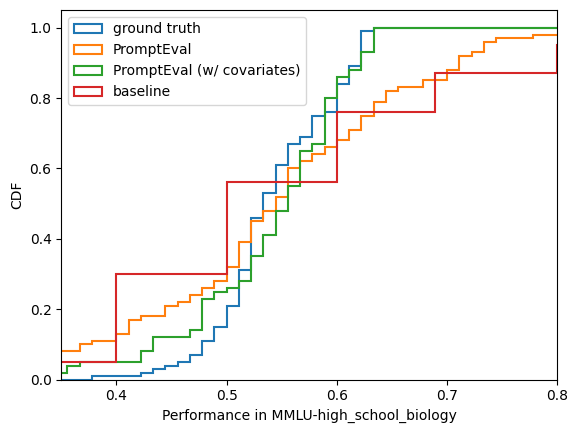

In [16]:
bins = np.linspace(0, 1.1, 100)
plt.hist(S, density=True, cumulative=True, bins=bins, histtype='step', linewidth=1.5, label='ground truth')
plt.hist(S_hat, density=True, cumulative=True, bins=bins, histtype='step', linewidth=1.5, label='PromptEval')
plt.hist(S_hat_cov, density=True, cumulative=True, bins=bins, histtype='step', linewidth=1.5, label='PromptEval (w/ covariates)')
plt.hist(S_hat_baseline, density=True, cumulative=True, bins=bins, histtype='step', linewidth=1.5, label='baseline')
plt.xlim(0.35,.8)
plt.legend(fontsize=10)
plt.xlabel(f"Performance in {benchmark}-{task}")
plt.ylabel("CDF")
plt.show()

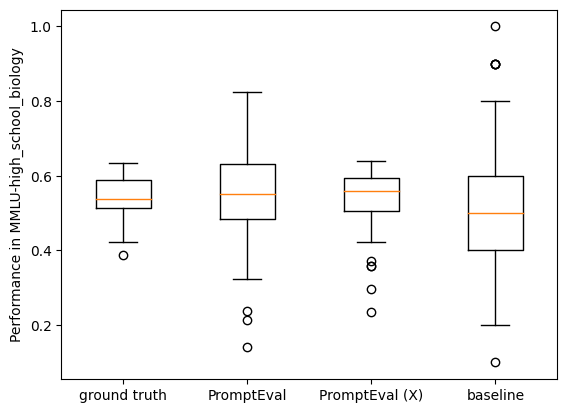

In [17]:
data = [S, S_hat, S_hat_cov, S_hat_baseline]
labels = ['ground truth', 'PromptEval', 'PromptEval (X)', 'baseline']
plt.boxplot(data, labels=labels)
plt.ylabel(f"Performance in {benchmark}-{task}")
plt.show()

The results improved with covariates.